<a href="https://colab.research.google.com/github/ichiyan/brain-decoding/blob/master/reconstruction_%5Btesting_canny%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!git clone https://github.com/ichiyan/brain-decoding.git

Cloning into 'brain-decoding'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 548 (delta 21), reused 26 (delta 9), pack-reused 497
Receiving objects: 100% (548/548), 513.73 MiB | 19.79 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Updating files: 100% (450/450), done.


In [2]:
cd /content/brain-decoding

/content/brain-decoding


In [ ]:
!git pull

## Install packages

In [6]:
!pip install -U git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-tyajv3qs
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-tyajv3qs
  Resolved https://github.com/huggingface/diffusers.git to commit aab6de22c33cc01fb7bc81c0807d6109e2c998c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.23.0.dev0-py3-none-any.whl size=1660809 sha256=44b18266c85eb156ca9db87d9711310f85ad055cd144dacd1f4e56056d4595bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-tu7t2uwo/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers


In [7]:
!pip install transformers accelerate safetensors clip open-clip-torch dalle2-pytorch typing-extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 43.7 MB/s eta 0:00:

In [9]:
!pip install einops torchvision omegaconf torchtext ml-collections gdown webdataset braceexpand

## Imports

In [5]:
cd /content/brain-decoding/scripts

/content/brain-decoding/scripts


In [10]:
import sys, os
sys.path.insert(1, '../mindeye/src/')

from diffusers import T2IAdapter,  EulerDiscreteScheduler, AutoencoderKL, MultiAdapter, StableDiffusionAdapterPipeline
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# import utils
from models import Clipper, BrainNetwork, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork, BrainDiffusionPrior

import clip
from clip_client import ClipClient, Modality
import urllib
import io

#for testing pick_best_recon
from tqdm import tqdm
import webdataset as wds
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

#for SD
from torch import autocast
from diffusers import StableDiffusionPipeline

#for Clip
import scipy
from IPython.display import display
from IPython.display import Image as IP_Image

import os
import requests
import math
import random
import json
import braceexpand
import torch.nn.functional as F
import time
from itertools import islice
import cv2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [11]:
subj_id = "01"
sub = 1
#for vdvae depth initial image
vdvae_num_layers = 47

test_batch_size = 1
local_rank = 0
num_devices = 1
num_workers = 1
seed = 0

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Load test data

In [13]:
# old implementation based from braindiffuser

# cd /content/drive

# gt_stim_test = np.load('/content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{:02d}/nsd_test_stim_sub1.npy'.format(subj,subj)).astype(np.uint8)
# caps_test = np.load('/content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{:02d}/nsd_test_cap_sub{}.npy'.format(subj,subj))
# fmri_test = np.load('/content/drive/MyDrive/brain_decoding/data/fMRI/NSD/processed-data/subj{:02d}/nsd_test_fmriavg_nsdgeneral_sub{}.npy'.format(subj,subj))
# pred_cliptext = np.load('../data/predicted_features/subj{:02d}/nsd_compel_cliptext_predtest_nsdgeneral.npy'.format(subj))
# pred_cliptext = torch.from_numpy(pred_cliptext)

In [14]:
print('Pulling NSD webdataset data...')

# urls should be local url
val_url = f"/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/test/test_subj{subj_id}_{{0..1}}.tar"
meta_url = f"/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/metadata_subj{subj_id}.json"

# mindeye code
# train_url = f"../data/train_subj01_"+"{0..2}.tar"
# val_url = f"../data/val_subj01_0.tar"
# meta_url = f"../data/metadata_subj01.json"

Pulling NSD webdataset data...


In [15]:
print('Prepping test dataloader...')
num_val = 982

Prepping test dataloader...


In [16]:
def get_dataloaders(
    image_var='images',
    num_devices=None,
    num_workers=None,
    val_url=None,
    meta_url=None,
    num_val=None,
    cache_dir="/tmp/wds-cache",
    seed=0,
    voxels_key="nsdgeneral.npy",
    val_batch_size=None,
    to_tuple=["voxels", "images", "trial"],
    local_rank=0,
    world_size=1,
    subj=1,
):
    print("Getting dataloaders...")
    assert image_var == 'images'

    def my_split_by_node(urls):
        return urls

    val_url = list(braceexpand.braceexpand(val_url))
    if not os.path.exists(val_url[0]):
        # we will default to downloading from huggingface urls if data_path does not exist
        print("downloading NSD from huggingface...")
        os.makedirs(cache_dir,exist_ok=True)


        test_url = get_huggingface_urls("main",subj)
        test_url = list(braceexpand.braceexpand(test_url))

        from tqdm import tqdm

        for url in tqdm(test_url):
            destination = cache_dir + "/" + url.rsplit('/', 1)[-1]
            print(f"\nDownloading {url} to {destination}...")
            response = requests.get(url)
            response.raise_for_status()
            with open(destination, 'wb') as file:
                file.write(response.content)

    if num_devices is None:
        num_devices = torch.cuda.device_count()

    if num_workers is None:
        num_workers = num_devices

    if num_val is None:
        metadata = json.load(open(meta_url))
        num_val = metadata['totals']['val']

    if val_batch_size is None:
        val_batch_size = batch_size

    global_batch_size = val_batch_size * num_devices
    num_batches = math.floor(num_val / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    if num_worker_batches == 0: num_worker_batches = 1

    print("\nnum_val",num_val)
    print("val_num_batches",num_batches)
    print("val_batch_size",val_batch_size)

    test_data = wds.WebDataset(test_url, resampled=False, cache_dir=cache_dir, nodesplitter=my_split_by_node)\
        .decode("torch")\
        .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
        .to_tuple(*to_tuple)\
        .batched(val_batch_size, partial=False)

    test_dl = torch.utils.data.DataLoader(test_data, batch_size=None, num_workers=1, shuffle=False)

    return test_dl, num_val

In [17]:
def get_huggingface_urls(commit='main',subj=1):
    base_url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/"
    test_url = base_url + commit + f"/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
    return test_url

In [18]:
print(f"Fetching data for subject {sub}...")
test_dl, num_test = get_dataloaders(
    num_devices=num_devices,
    num_workers=num_workers,
    val_url=val_url,
    meta_url=meta_url,
    val_batch_size=test_batch_size,
    cache_dir='/tmp/wds-cache',
    seed=seed+local_rank,
    voxels_key='nsdgeneral.npy',
    local_rank=local_rank,
    # num_train=num_train,
    num_val=num_val,
    subj=sub
)

Fetching data for subject 1...
Getting dataloaders...
downloading NSD from huggingface...


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:16<01:16, 76.32s/it]

100%|██████████| 2/2 [02:19<00:00, 69.92s/it]


num_val 982
val_num_batches 982
val_batch_size 1


## load BrainNetwork (voxel2clip) and Diffusion Prior

In [19]:
if sub == 1:
    num_voxels = 15724
elif sub == 2:
    num_voxels = 14278
elif sub == 3:
    num_voxels = 15226
elif sub == 4:
    num_voxels = 13153
elif sub == 5:
    num_voxels = 13039
elif sub == 6:
    num_voxels = 17907
elif sub == 7:
    num_voxels = 12682
elif sub == 8:
    num_voxels = 14386
print("sub",sub,"num_voxels",num_voxels)

sub 1 num_voxels 15724


In [20]:
cd /content/brain-decoding/data/

/content/brain-decoding/data


In [21]:
!cp -r /content/drive/MyDrive/brain_decoding/data/mindeye-high-level/prior_1x768_final_subj01_bimixco_softclip_byol/last.pth /content/brain-decoding/mindeye/train_logs/prior_1x768_final_subj01_bimixco_softclip_byol
!cp -r /content/drive/MyDrive/brain_decoding/data/mindeye-high-level/checkpoints/prior_config.json /content/brain-decoding/mindeye/checkpoints
!cp -r /content/drive/MyDrive/brain_decoding/data/mindeye-high-level/checkpoints/best.pth /content/brain-decoding/mindeye/checkpoints

In [22]:
# CLS model
out_dim = 768
clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=False, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

diffusion_prior = BrainDiffusionPriorOld.from_pretrained(
    # kwargs for DiffusionPriorNetwork
    dict(),
    # kwargs for DiffusionNetwork
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
    voxel2clip_path=None,
    ckpt_dir='../mindeye/checkpoints',
)

model_name = "prior_1x768_final_subj01_bimixco_softclip_byol"
outdir = f'../mindeye/train_logs/{model_name}/'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]

ViT-L/14 cuda


100%|███████████████████████████████████████| 933M/933M [00:17<00:00, 52.5MiB/s]


ckpt_path ../mindeye/train_logs/prior_1x768_final_subj01_bimixco_softclip_byol/last.pth
EPOCH:  299


## function to get CLIP embeddings from fMRI

In [23]:
def get_clip_embeddings(voxels, diffusion_prior, recons_per_sample=1, seed=0):
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)
    brain_clip_embeddings0, proj_embeddings = diffusion_prior.voxel2clip(voxels.to(device).float())
    # brain_clip_embeddings0 = brain_clip_embeddings0.view(len(voxels),-1,768)
    brain_clip_embeddings0 = brain_clip_embeddings0.view(-1,768)
    brain_clip_embeddings0 = brain_clip_embeddings0.repeat(recons_per_sample, 1)
    brain_clip_embeddings = diffusion_prior.p_sample_loop(brain_clip_embeddings0.shape,
                            text_cond = dict(text_embed = brain_clip_embeddings0),
                            cond_scale = 1., timesteps = 1000, #1000 timesteps used from nousr pretraining
                            generator=generator)
    brain_clip_embeddings = brain_clip_embeddings.unsqueeze(1) #(1,1,768)

    return brain_clip_embeddings, proj_embeddings

## load CLIP Client and ClIP retrieval functions

In [24]:
model, preprocess = clip.load("ViT-L/14", device="cpu", jit=False)

num_images=10

client = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-L-14",
    aesthetic_score=9,
    aesthetic_weight=0.5,
    modality=Modality.IMAGE,
    num_images=300,
    use_mclip=False,
    use_violence_detector=False,
    use_safety_model=False
)

backup_client = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-L-14",
    num_images=300,
    aesthetic_score=5,
    aesthetic_weight=1,
    use_violence_detector=False,
    use_safety_model=False
)

In [25]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    # display(Image(url=url, unconfined=True))

def download_image(url):
    urllib_request = urllib.request.Request(
        url,
        data=None,
        headers={"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:72.0) Gecko/20100101 Firefox/72.0"},
    )
    with urllib.request.urlopen(urllib_request, timeout=10) as r:
        img_stream = io.BytesIO(r.read())
    return img_stream

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def get_text_emb(text):
    with torch.no_grad():
        text_emb = model.encode_text(clip.tokenize([text], truncate=True).to("cpu"))
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu().detach().numpy().astype("float32")[0]
    return text_emb


def get_image_emb(image_url):
    with torch.no_grad():
        image = Image.open(download_image(image_url))
        image_emb = model.encode_image(preprocess(image).unsqueeze(0).to("cpu"))
        image_emb /= image_emb.norm(dim=-1, keepdim=True)
        image_emb = image_emb.cpu().detach().numpy().astype("float32")[0]
        return image_emb

## load Stable Diffusion with T2I Adapters

In [26]:
adapters = MultiAdapter(
    [
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16),
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_depth_sd14v1", torch_dtype=torch.float16),
        T2IAdapter.from_pretrained("TencentARC/t2iadapter_canny_sd14v1", torch_dtype=torch.float16),
    ]
)

model_id = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16)
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapters, scheduler=scheduler, torch_dtype=torch.float16, variant="fp16"
).to(device)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## load SD only


In [27]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

sd_pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
sd_pipe = sd_pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## Reconstruction/Inference

In [ ]:
# load coco annots

In [28]:
def get_color_pallete(img):
    img = img.resize((8,8))
    color_pallete = img.resize((512, 512), resample=Image.Resampling.NEAREST)

    return color_pallete

In [29]:
def get_pseudoprompt(embs):
    try:
        res = client.query(embedding_input=embs.tolist())
    except:
        try:
            time.sleep(2)
            res = backup_client.query(embedding_input=embs.tolist())
        except:
            return -1

    return res[0]  #first result has the highest similarity score

In [30]:
def handle_query_error(curr_voxels_iter, total, curr_recons_iter, num_fails):
    num_fails += 1
    print(f"Pseudo-prompt query failed for brain sample no.{curr_voxels_iter}, reconstruction no.{curr_recons_iter} probably due to server error." \
          f" Total number of images to be generated is {total - num_fails}.")
    return num_fails

In [31]:
def batchwise_cosine_similarity(Z,B):
    # https://www.h4pz.co/blog/2021/4/2/batch-cosine-similarity-in-pytorch-or-numpy-jax-cupy-etc
    B = B.T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity

In [32]:
# # pick best reconstruction out of several
def pick_best_recon (val_i, n_samples_save, proj_embeddings, brain_recons, recons_per_sample, verbose):
  cosine_best_picks = np.zeros(n_samples_save).astype(np.int16)
  ssim_best_picks = np.zeros(n_samples_save).astype(np.int16)
  avg_best_picks = np.zeros(n_samples_save).astype(np.int16)

  v2c_reference_out = nn.functional.normalize(proj_embeddings.view(len(proj_embeddings),-1),dim=-1)
  sims=[]
  ssim_r=[]
  avg_r = []

  base_dir = f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{sub:02d}/'.format(sub)
  base_image = Image.open(base_dir +str(val_i)+'.png')
  base_image = np.array(base_image)/255.0
  base_image = rgb2gray(base_image)
  # print(base_dir +str(val_i)+'.png')

  #Compute Cosine Similarity
  for im in range(recons_per_sample):
    brain_recon_tensor = transforms.PILToTensor()(brain_recons[im]).unsqueeze(0).float()
    currecon = clip_extractor.embed_image(brain_recon_tensor).to(proj_embeddings.device).to(proj_embeddings.dtype)
    currecon = nn.functional.normalize(currecon.view(len(currecon),-1),dim=-1)
    cursim = batchwise_cosine_similarity(v2c_reference_out,currecon)
    # print(im, "cursim", cursim)

    #SSIM => compare w/ initial img
  brain_recon_PIL = np.array(brain_recons[im])/255.0
  brain_recon_PIL = rgb2gray(brain_recon_PIL)
  ssim_res = ssim(brain_recon_PIL, base_image, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0)

  #place results in list
  ssim_r.append(ssim_res.item())
  sims.append(cursim.item())
  avg_r.append(np.average([ssim_res.item(), cursim.item()]))

  if verbose: print("sims: ", sims)
  cosine_best_picks[0] = int(np.nanargmax(sims))
  ssim_best_picks[0] = int(np.nanargmax(ssim_r))
  avg_best_picks[0] = int(np.nanargmax(avg_r))
  if verbose:
    print("best_pick using cosine: ", cosine_best_picks)
    print("best_pick using SSIM: ", ssim_best_picks)
    print("best_pick using both: ", avg_best_picks)

  return cosine_best_picks, ssim_best_picks, avg_best_picks

In [36]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [33]:
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
sd_seed = 777
generator = torch.manual_seed(sd_seed)
ind_include = np.arange(num_val)

recons_per_sample = 4
seed = 42
guidance_scale = 7.5
num_inference_steps = 50
color_scale = 0.8
depth_scale = 0.8
canny_scale = 0.8

low_threshold = 100
high_threshold = 150

n_samples_save = 1   #how many best picks
verbose = False

In [49]:
# reconstruct one at a time

# uncomment later
# for ndx, (voxels, img, coco) in enumerate(tqdm(test_dl,total=len(ind_include))):

# remove later
val_i = 1
num_test = 982
for ndx, (voxels, img, coco) in enumerate(tqdm(islice(test_dl, val_i, num_test))):
    ndx = ndx + val_i

    if ndx < np.min(ind_include):
        continue

    if verbose: print(ndx)

    voxels = torch.mean(voxels,axis=1) #.to(device)
    brain_clip_embs, proj_embs = get_clip_embeddings(voxels.unsqueeze(0), diffusion_prior, recons_per_sample=recons_per_sample, seed=seed)

    lvae_init_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/lvae/subj{subj_id}/{ndx}.png')
    color_pallete = get_color_pallete(lvae_init_img)

    depth_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae/subj{subj_id}/{ndx}.png')

    blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
    blurry_img = np.array(blurry_img)
    canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
    canny_img = Image.fromarray(canny_img)

    gen_images = []
    failed_queries = 0

    for emb_i in range(len(brain_clip_embs)):
        # returns first result or -1 if there is an error in client
        res = get_pseudoprompt(brain_clip_embs[emb_i][0]) # input to client.query is torch.Size([768])

        new_seed = seed
        while len(res) == 0:
            new_seed += 111
            embs, _ = get_clip_embeddings(
                voxels.unsqueeze(0),
                diffusion_prior,
                recons_per_sample=1,
                seed=new_seed
            )

            res = get_pseudoprompt(embs[0][0])
            if res == -1:
                break

        if res == -1:
             failed_queries = handle_query_error(ndx, recons_per_sample, emb_i, failed_queries)
             continue

        if verbose:
            log_result(res)

        new_seed = sd_seed

        while True:
            gen_image = pipe(
              prompt = res["caption"],
              negative_prompt=negative_prompt,
              # image=[color_pallete, depth_img],
              # adapter_conditioning_scale=[color_scale, depth_scale],
              image=[color_pallete, depth_img, canny_img],
              adapter_conditioning_scale=[color_scale, depth_scale, canny_scale],
              num_inference_steps=num_inference_steps,
              guidance_scale=guidance_scale,
              generator=generator,
              num_images_per_prompt=1,
            ).images[0]

            # check if generated image is not all black (SD returns all black image if generated image is NSFW)
            if gen_image.getbbox():  #returns the falsy None if there are no non-black pixels in the image, otherwise it returns a tuple of points, which is truthy.)
                if new_seed != sd_seed:
                    generator = torch.manual_seed(sd_seed)
                break
            new_seed += 111
            generator = torch.manual_seed(new_seed)

        gen_images.append(gen_image)

    if len(gen_images) > 1:
        cosine_best_picks, ssim_best_picks, avg_best_picks = pick_best_recon(emb_i, n_samples_save, proj_embs, gen_images, len(gen_images), verbose)
        best_picks = avg_best_picks
    else:
        best_picks = [0]

    for im_i, img in enumerate(gen_images):
        filename = f"{ndx}_{im_i}"
        if im_i == best_picks[0]:
            filename = f"{ndx}_best"

        img.save(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/sd_t2i/subj{subj_id}/new{filename}.png')

    break


0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/t2i_adapter/pipeline_stable_diffusion_adapter.py:454: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-32-3610767f125e>:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_res = ssim(brain_recon_PIL, base_image, multichannel=True, gaussian_weights=True, s

## Test - canny images

In [47]:
ndx=239
subj_id='01'
low_threshold = 50
high_threshold = 200

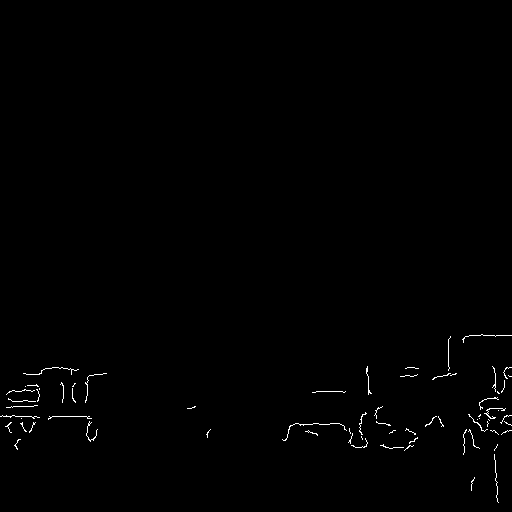

In [38]:
# 100-150
blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
blurry_img = np.array(blurry_img)
canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
canny_img = Image.fromarray(canny_img)
canny_img

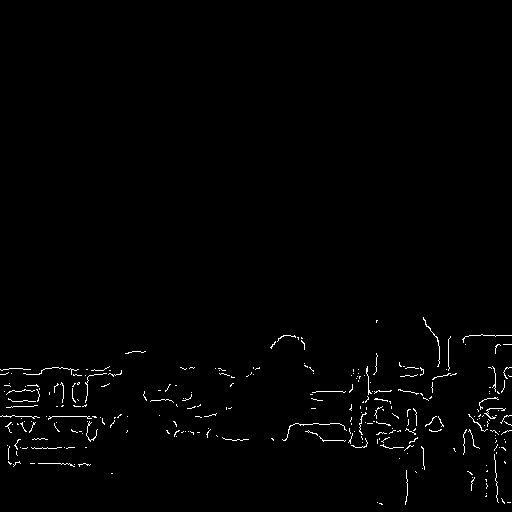

In [40]:
# ==
blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
blurry_img = np.array(blurry_img)
canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
canny_img = Image.fromarray(canny_img)
canny_img

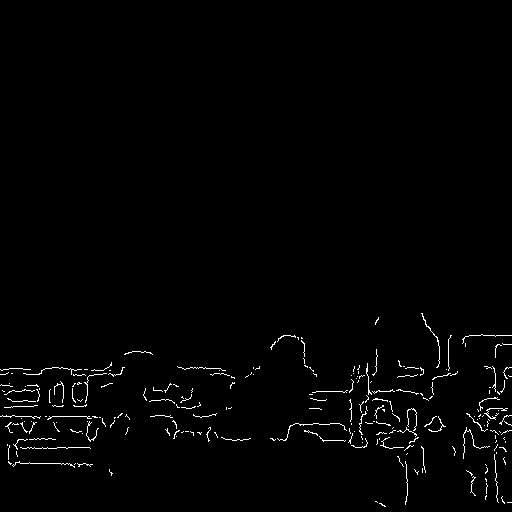

In [42]:
#80-100
blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
blurry_img = np.array(blurry_img)
canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
canny_img = Image.fromarray(canny_img)
canny_img

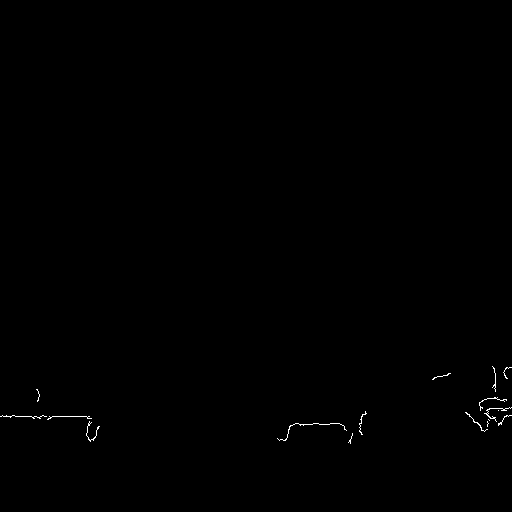

In [48]:
#low=50
blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
blurry_img = np.array(blurry_img)
canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
canny_img = Image.fromarray(canny_img)
canny_img

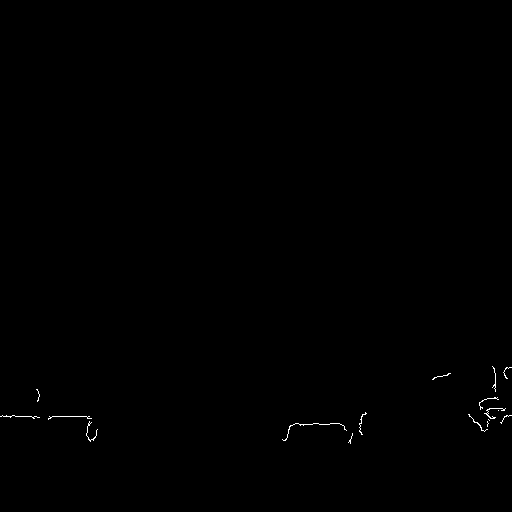

In [44]:
#OG
blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
blurry_img = np.array(blurry_img)
canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
canny_img = Image.fromarray(canny_img)
canny_img

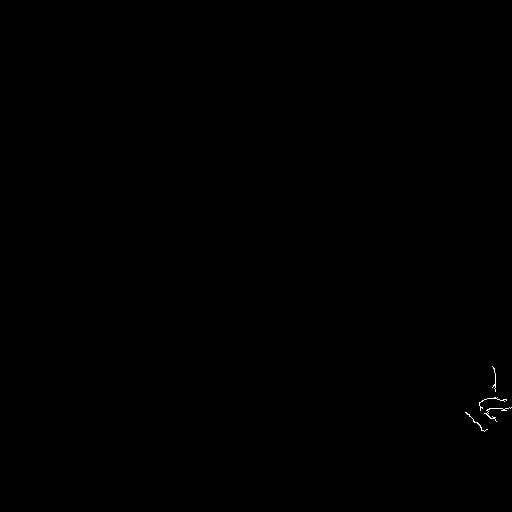

In [46]:
#4  low=50 & high=250
blurry_img = Image.open(f'/content/drive/MyDrive/brain_decoding/data/reconstructed/vdvae_blurry/subj{subj_id}/{ndx}.png')
blurry_img = np.array(blurry_img)
canny_img = cv2.Canny(blurry_img, low_threshold, high_threshold)
canny_img = Image.fromarray(canny_img)
canny_img

## Test gen images

In [50]:
print(val_i)
ndx

1


1

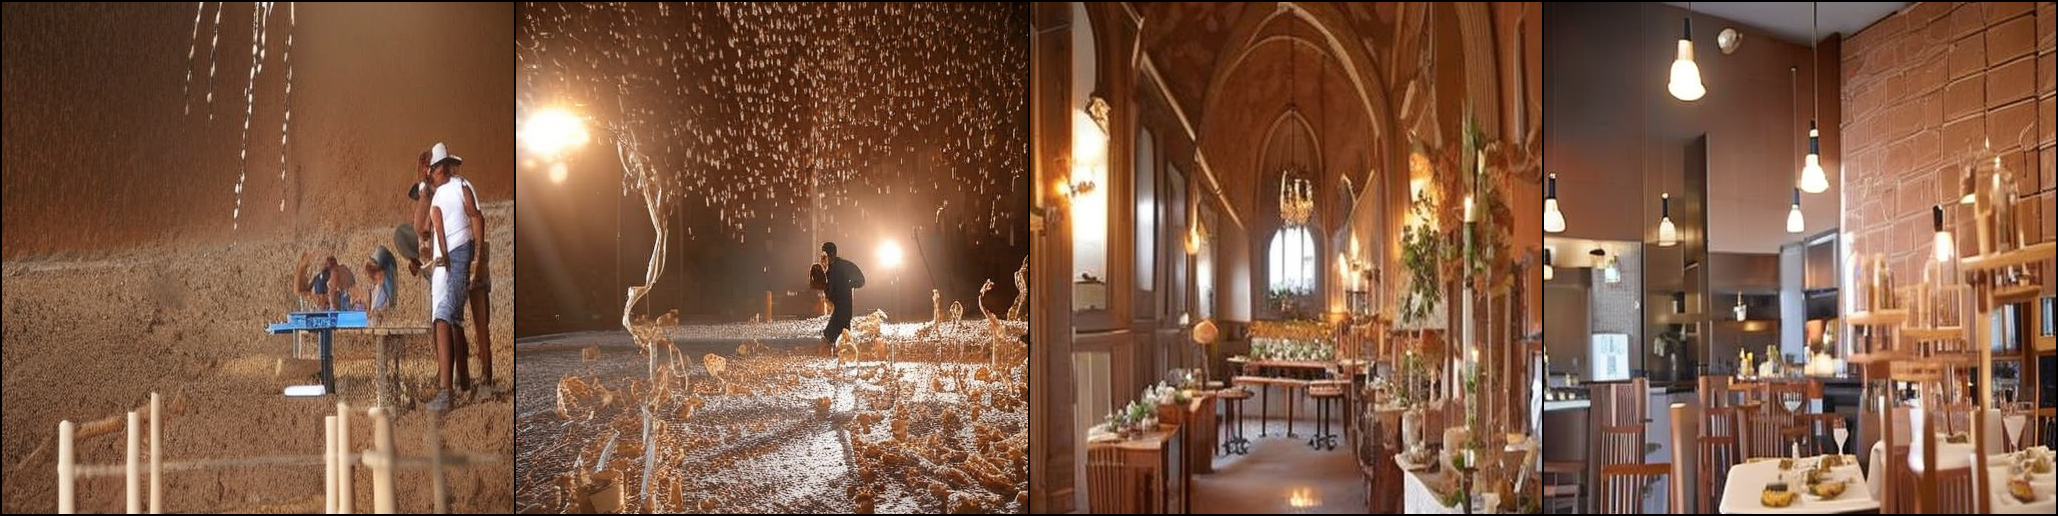

In [51]:
#4  low=100 & high=150
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=4)
grid = transforms.ToPILImage()(grid)
grid

In [ ]:
#4  low=50 & high=250
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=4)
grid = transforms.ToPILImage()(grid)
grid

In [ ]:
#high == 250
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=4)
grid = transforms.ToPILImage()(grid)
grid

In [ ]:
#low==50
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=4)
grid = transforms.ToPILImage()(grid)
grid

In [ ]:
#1 OG
images = [transform(im) for im in gen_images]
grid = make_grid(images, nrow=4)
grid = transforms.ToPILImage()(grid)
grid

## SDXL Refine

In [ ]:
from diffusers import StableDiffusionXLImg2ImgPipeline

In [ ]:
refiner_pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=False
)

In [ ]:
# test captions from query
# test fmri-sdxl cliptext regression


refiner_images = refiner_pipe(
  # prompt_embeds=pred_opencliptext[ndx].unsqueeze(0).to(device),
  # pooled_prompt_embeds=pred_pooledtext[ndx].unsqueeze(0).to(device),
  # prompt_embeds=conditioning2,
  # pooled_prompt_embeds=pooled2,
  prompt=res["caption"],
  negative_prompt=negative_prompt,
  # image=init_img,
  # image=gen_images[2],
  image=gen_images[best_picks[0]],
  # default strength is 0.3
  # strength=0.5,
  num_inference_steps=50,
  guidance_scale=7.5,
  num_images_per_prompt=3
).images